<a href="https://colab.research.google.com/github/Jegge2003/GoogleCollabTrials/blob/main/cnn_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 style='color:blue' align='center'>Transfer learning in image classification</h2>

**In this notebook we will use transfer learning and take pre-trained model from google's Tensorflow Hub and re-train that on flowers dataset. Using pre-trained model saves lot of time and computational budget for new classification problem at hand**

In [1]:
#Uploading files from local machine
from google.colab import files
files.upload()

Saving goldfish.jpg to goldfish.jpg
Saving ImageNetLabels.txt to ImageNetLabels.txt


{'ImageNetLabels.txt': b"background\ntench\ngoldfish\ngreat white shark\ntiger shark\nhammerhead\nelectric ray\nstingray\ncock\nhen\nostrich\nbrambling\ngoldfinch\nhouse finch\njunco\nindigo bunting\nrobin\nbulbul\njay\nmagpie\nchickadee\nwater ouzel\nkite\nbald eagle\nvulture\ngreat grey owl\nEuropean fire salamander\ncommon newt\neft\nspotted salamander\naxolotl\nbullfrog\ntree frog\ntailed frog\nloggerhead\nleatherback turtle\nmud turtle\nterrapin\nbox turtle\nbanded gecko\ncommon iguana\nAmerican chameleon\nwhiptail\nagama\nfrilled lizard\nalligator lizard\nGila monster\ngreen lizard\nAfrican chameleon\nKomodo dragon\nAfrican crocodile\nAmerican alligator\ntriceratops\nthunder snake\nringneck snake\nhognose snake\ngreen snake\nking snake\ngarter snake\nwater snake\nvine snake\nnight snake\nboa constrictor\nrock python\nIndian cobra\ngreen mamba\nsea snake\nhorned viper\ndiamondback\nsidewinder\ntrilobite\nharvestman\nscorpion\nblack and gold garden spider\nbarn spider\ngarden spide

In [2]:
# Install tensorflow_hub using pip install tensorflow_hub first

In [24]:
!pip install tensorflow_hub
!pip install pillow
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Make predictions using ready made model (without any training)**

In [4]:
#Setting the size of the image
IMAGE_SHAPE = (224, 224)
#Importing ready made model from tensorflow
classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

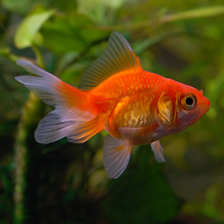

In [5]:
gold_fish = Image.open("goldfish.jpg").resize(IMAGE_SHAPE)
gold_fish

In [6]:
#Normalizing the data of the goldfish between 0 and 1
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [7]:
#Adding one more dimension since prediction accept more images as input and not only one image
gold_fish[np.newaxis, ...]

array([[[[0.28235294, 0.33333333, 0.07058824],
         [0.31372549, 0.37254902, 0.09019608],
         [0.34901961, 0.41960784, 0.11764706],
         ...,
         [0.32941176, 0.39215686, 0.00392157],
         [0.32156863, 0.38431373, 0.00392157],
         [0.30980392, 0.36862745, 0.        ]],

        [[0.28627451, 0.33333333, 0.08235294],
         [0.3254902 , 0.38039216, 0.10980392],
         [0.35294118, 0.42352941, 0.12941176],
         ...,
         [0.32156863, 0.38039216, 0.00392157],
         [0.31372549, 0.37254902, 0.00392157],
         [0.30196078, 0.36078431, 0.        ]],

        [[0.28627451, 0.33333333, 0.08627451],
         [0.31372549, 0.36862745, 0.10196078],
         [0.34509804, 0.41568627, 0.12941176],
         ...,
         [0.31764706, 0.37647059, 0.00392157],
         [0.30980392, 0.36862745, 0.00784314],
         [0.29803922, 0.35686275, 0.00392157]],

        ...,

        [[0.05490196, 0.10980392, 0.01568627],
         [0.05098039, 0.11372549, 0.01960784]

In [8]:
#Making prediction with the ready made model from tensorflow
result = classifier.predict(gold_fish[np.newaxis, ...])
result.shape

(1, 1001)

In [9]:
#Finding the index that has the maximum value
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [11]:
# tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
#Opening file with image label names and displaying the first 5 of it
image_labels = []
with open("ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [12]:
image_labels[predicted_label_index]

'goldfish'

<h3 style='color:purple'>Load flowers dataset</h3>

In [13]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

228827136/228813984 [==============================] - 4s 0us/step


In [14]:
data_dir

'./datasets/flower_photos'

In [15]:
#Changing into PosixPath for easy accessing and querying
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [16]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/roses/4248222578_b4d5868b32.jpg'),
 PosixPath('datasets/flower_photos/roses/8742493689_fb852f0228_n.jpg'),
 PosixPath('datasets/flower_photos/roses/12240165555_98625b1e88_n.jpg'),
 PosixPath('datasets/flower_photos/roses/2197754124_5c8a146761_n.jpg'),
 PosixPath('datasets/flower_photos/roses/180613732_3a7aba0b80_n.jpg')]

In [20]:
#length of pictures in directory
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [21]:
#Creating Roses list for all roses in data
#Displaying the first 5 rose PosixPath pictures
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/4248222578_b4d5868b32.jpg'),
 PosixPath('datasets/flower_photos/roses/8742493689_fb852f0228_n.jpg'),
 PosixPath('datasets/flower_photos/roses/12240165555_98625b1e88_n.jpg'),
 PosixPath('datasets/flower_photos/roses/2197754124_5c8a146761_n.jpg'),
 PosixPath('datasets/flower_photos/roses/180613732_3a7aba0b80_n.jpg')]

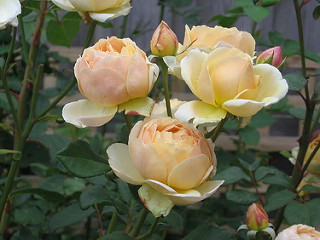

In [26]:
#Using pillow to open the files
Image.open(str(roses[1]))

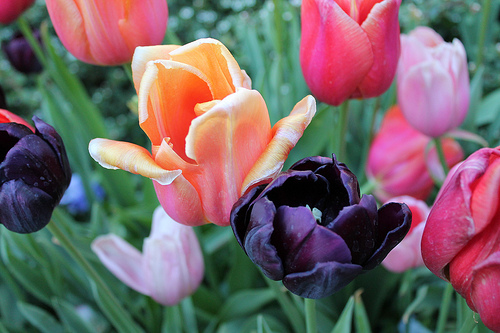

In [27]:
#Creating tulips list for all tulips in data
tulips = list(data_dir.glob('tulips/*'))
Image.open(str(tulips[0]))

<h3 style='color:purple'>Read flowers images from disk into numpy array using opencv</h3>

In [28]:
#Setting up a dictionary to hold all the various lists for the various kinds of pictures we have
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [30]:
#Setting various labels for the various classes of flowers we are working with
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [31]:
flowers_images_dict['roses'][:5]

[PosixPath('datasets/flower_photos/roses/4248222578_b4d5868b32.jpg'),
 PosixPath('datasets/flower_photos/roses/8742493689_fb852f0228_n.jpg'),
 PosixPath('datasets/flower_photos/roses/12240165555_98625b1e88_n.jpg'),
 PosixPath('datasets/flower_photos/roses/2197754124_5c8a146761_n.jpg'),
 PosixPath('datasets/flower_photos/roses/180613732_3a7aba0b80_n.jpg')]

In [32]:
str(flowers_images_dict['roses'][0])

'datasets/flower_photos/roses/4248222578_b4d5868b32.jpg'

In [33]:
#Reading image from a specified file location
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [34]:
#Displaying image shape
img.shape

(264, 500, 3)

In [36]:
#Resizing image to a workable shape
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [37]:
#Making an X and Y dataset 
X, y = [], []

#Loop to load all images, resize them, and append them into X and Y lists for training
for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [38]:
#Changing X and Y into numpy arrays
X = np.array(X)
y = np.array(y)

<h3 style='color:purple'>Train test split</h3>

In [39]:
#Splitting data into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

<h3 style='color:purple'>Preprocessing: scale images</h3>

In [41]:
#Normalizing data from 0 to 1
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

**Make prediction using pre-trained model on new flowers dataset**

In [42]:
#Displaying shape of first X value
X[0].shape

(224, 224, 3)

In [43]:
#Setting up a new image shape variable
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [44]:
#Resizing the pictures
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

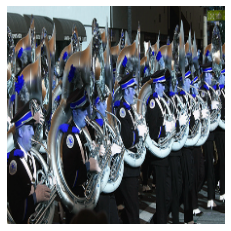

In [45]:
#Setting axis off and displaying first X list value
plt.axis('off')
plt.imshow(X[0])

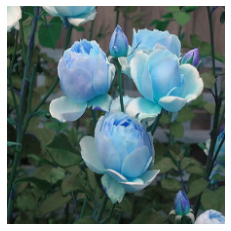

In [46]:
#Setting axis off and displaying second X list value
plt.axis('off')
plt.imshow(X[1])

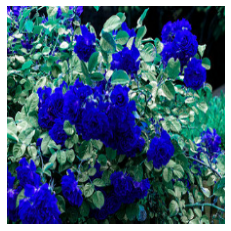

In [48]:
#Setting axis off and displaying third X list value
plt.axis('off')
plt.imshow(X[2])

In [49]:
#Using ready trained model to make prediction for first 3 X values of the list
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

array([722, 795, 550])

In [50]:
#Showing the exact image label for 795
image_labels[795]

'shower curtain'

<h3 style='color:purple'>Now take pre-trained model and retrain it using flowers images</h3>

In [51]:
#Bringing the mobilenet v2 pre-trained model
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
#Loading the model and freezing it so that it doesn't get trained with our new dataset but only used for predictions
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [52]:
#Setting up the number of flowers to be predicted
num_of_flowers = 5
#Bringing the pre-trained model and setting up 5 Dense layers for our 5 classes we want to predict
model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [53]:
#Compiling model
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])
#Running only 5 epochs
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 69s 759ms/step - loss: 0.8289 - acc: 0.6857
Epoch 2/5
86/86 [==============================] - 66s 762ms/step - loss: 0.4166 - acc: 0.8547
Epoch 3/5
86/86 [==============================] - 66s 763ms/step - loss: 0.3232 - acc: 0.8895
Epoch 4/5
86/86 [==============================] - 65s 761ms/step - loss: 0.2729 - acc: 0.9142
Epoch 5/5
86/86 [==============================] - 66s 763ms/step - loss: 0.2328 - acc: 0.9291


In [54]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 22s 754ms/step - loss: 0.3944 - acc: 0.8595


[0.3943954408168793, 0.8594771027565002]